<a href="https://colab.research.google.com/github/dev02chandan/Biometrics-Project/blob/main/Biometric_Masked_Face_Identification_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Aim:

Our aim in this project is to create a biometric identification system using face recognition for faces wearing masks. This project was inspired by the COVID-19 pandemic, which was a serious health risk that prompted people to start wearing masks.


### Contributors: 

1. Aryan Bhapkar
2. Manasi Pawaskar
3. Dev Chandan

### Import Dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import shutil
import zipfile
import tensorflow as tf

In [3]:
path_arcface = '/content/drive/MyDrive/Colab Notebooks/arcface.h5'

In [8]:
original_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Biometrics/ourdataset 1.1 (1).zip'

In [9]:
dataset_path = '/content/dataset'

In [10]:
zip_file_path = original_dataset_path
destination_dir = dataset_path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the contents of the zip file to a temporary directory
    zip_ref.extractall("temp_directory")
    
# Move each subdirectory to the destination directory
for subdirectory in os.listdir("temp_directory"):
    shutil.move(os.path.join("temp_directory", subdirectory), destination_dir)

# Remove the temporary directory
shutil.rmtree("temp_directory")


In [11]:
!rm -r '/content/dataset/Masked'

In [12]:
!rm -r '/content/dataset/Unmasked'

In [13]:
!mv '/content/dataset/104' '/content/dataset/48'

In [ ]:
# Copy a directory from Colab files section to your Google Drive
# !cp -r "/content/dataset" "/content/drive/My Drive/Colab Notebooks/Biometrics/"

### Pre-processing and Image detection

In [14]:
folders = os.listdir(dataset_path)

In [15]:
len(folders)

103

In [16]:
num_folders = 90

In [17]:
selected_folders = np.random.choice(folders, num_folders, replace = False)

In [18]:
len(selected_folders)

90

In [20]:
new_dataset_path = '/content/dataset_detected'

In [21]:
if not os.path.exists(new_dataset_path):
    os.makedirs(new_dataset_path)

In [22]:
import os
import glob

def count_subfolders_with_more_than_15_images(directory_path):
    subfolders = []
    for root, dirs, files in os.walk(directory_path):
        for dir in dirs:
            subfolders.append(os.path.join(root, dir))

    num_images = {}
    for folder in subfolders:
        num_images[folder] = len(glob.glob(folder + "/*.jpg")) + len(glob.glob(folder + "/*.jpeg")) + len(glob.glob(folder + "/*.png"))

    count = 0
    for folder, num in num_images.items():
        if num > 15:
            count += 1
    return count


In [23]:
directory_path = dataset_path
count = count_subfolders_with_more_than_15_images(directory_path)
print("Number of subfolders with more than 15 images:", count)

Number of subfolders with more than 15 images: 195


In [24]:
import os

def count_folders_and_images(directory_path):
    folder_count = 0
    image_count = 0

    # Iterate over all directories and files in the directory
    for root, dirs, files in os.walk(directory_path):
        folder_count += len(dirs) # Increment folder count for each subdirectory
        for file in files:
            # Increment image count for each file with extension .jpg, .png or .jpeg
            if file.endswith(('.jpg', '.png', '.jpeg')):
                image_count += 1

    print("Number of folders:", folder_count)
    print("Number of images:", image_count)


In [25]:
def faceDetection(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.01, minNeighbors=1, minSize=(110, 110))

    # Find the largest face detected
    largest_area = 0
    largest_rect = None
    for (x, y, w, h) in faces:
        rect_area = w * h
        if rect_area > largest_area:
            largest_area = rect_area
            largest_rect = (x, y, w, h)

    # If a face is detected, save it to the output folder
    if largest_rect is not None:
        x, y, w, h = largest_rect
        face = img[y:y+h, x:x+w]
        return face
    
    else:
      return None

In [26]:
# Set the original and new directories
original_dir = '/content/dataset'
new_dir = '/content/combined'

# Loop through each folder in the original directory
for folder in os.listdir(original_dir):
    # Skip any files in the original directory
    if not os.path.isdir(os.path.join(original_dir, folder)):
        continue

    # Create a new folder in the new directory
    new_folder = os.path.join(new_dir, folder)
    os.makedirs(new_folder, exist_ok=True)

    # Loop through the masked and unmasked folders in the current folder
    for subfolder in ('Masked', 'Unmasked'):
        subfolder_path = os.path.join(original_dir, folder, subfolder)

        # Skip the subfolder if it doesn't exist
        if not os.path.exists(subfolder_path):
            continue

        # Loop through each file in the subfolder and move it to the new folder
        for file in os.listdir(subfolder_path):
            src = os.path.join(subfolder_path, file)
            dst = os.path.join(new_folder, file)
            shutil.move(src, dst)

        # Remove the now-empty subfolder
        os.rmdir(subfolder_path)


In [27]:
import os
import cv2

def extract_faces(selected_folders, dataset_path, new_dataset_path, num_folders):
    total_folders = 0

    for folder in selected_folders:
        folder_path = os.path.join(dataset_path, folder)
        images = os.listdir(folder_path)

        # Only process the folder if it has at least 30 images and
        # we haven't already processed 5 folders
        if len(images) >= 20 and total_folders < num_folders:
            total_folders += 1
            j = 0  # counter for the number of images saved to the output folder

            # Loop through each image in the folder
            for image_name in images:
                image_path = os.path.join(folder_path, image_name)
                img = cv2.imread(image_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.01, minNeighbors=1, minSize=(110, 110))

                # Find the largest face detected
                largest_area = 0
                largest_rect = None
                for (x, y, w, h) in faces:
                    rect_area = w * h
                    if rect_area > largest_area:
                        largest_area = rect_area
                        largest_rect = (x, y, w, h)

                # If a face is detected, save it to the output folder
                if largest_rect is not None and j < 30:
                    x, y, w, h = largest_rect
                    face = img[y:y+h, x:x+w]
                    output_dir = os.path.join(new_dataset_path, folder)

                    # Create the output directory if it doesn't exist
                    if not os.path.exists(output_dir) and total_folders <= num_folders:
                        os.makedirs(output_dir)

                    # Save the face image to the output directory
                    new_image_path = os.path.join(output_dir, image_name)
                    # face_image = cv2.resize(face, (112, 112))
                    cv2.imwrite(new_image_path, face)

                    # Increment the counter
                    j += 1

                    # Break the loop if we've saved 15 images to the output folder
                    if j == 20:
                        break


new_dir = '/content/combined'
folders = os.listdir(new_dir)
num_folders = 90
selected_folders = np.random.choice(folders, num_folders, replace = False)
new_dataset_path = '/content/dataset_detected'
extract_faces(selected_folders, new_dir, new_dataset_path, num_folders)


### Train and Test Split (mix data)

In [122]:
# Set the path to the directory containing the face images
face_dir = '/content/dataset_detected'

In [123]:
img_height, img_width = 112, 112

In [124]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  face_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=64)

Found 1719 files belonging to 88 classes.
Using 1376 files for training.


In [125]:
train_ds_int = tf.keras.utils.image_dataset_from_directory(
  face_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='int',
  batch_size=64)

Found 1719 files belonging to 88 classes.
Using 1376 files for training.


In [126]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  face_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=64)

Found 1719 files belonging to 88 classes.
Using 343 files for validation.


In [127]:
val_ds_int = tf.keras.utils.image_dataset_from_directory(
  face_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='int',
  batch_size=64)

Found 1719 files belonging to 88 classes.
Using 343 files for validation.


In [128]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '014', '015', '016', '017', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '042', '043', '044', '045', '046', '048', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '065', '066', '067', '069', '070', '071', '073', '074', '075', '076', '078', '080', '084', '085', '086', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '48']
88


### Image Plotting

(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)


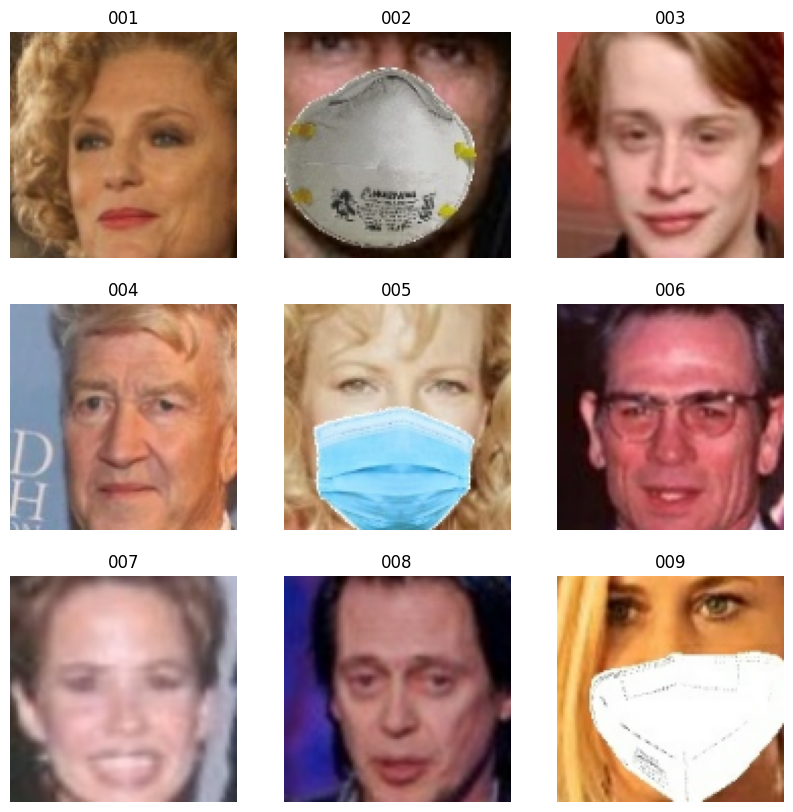

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    print(images[i].shape)
    plt.axis("off")

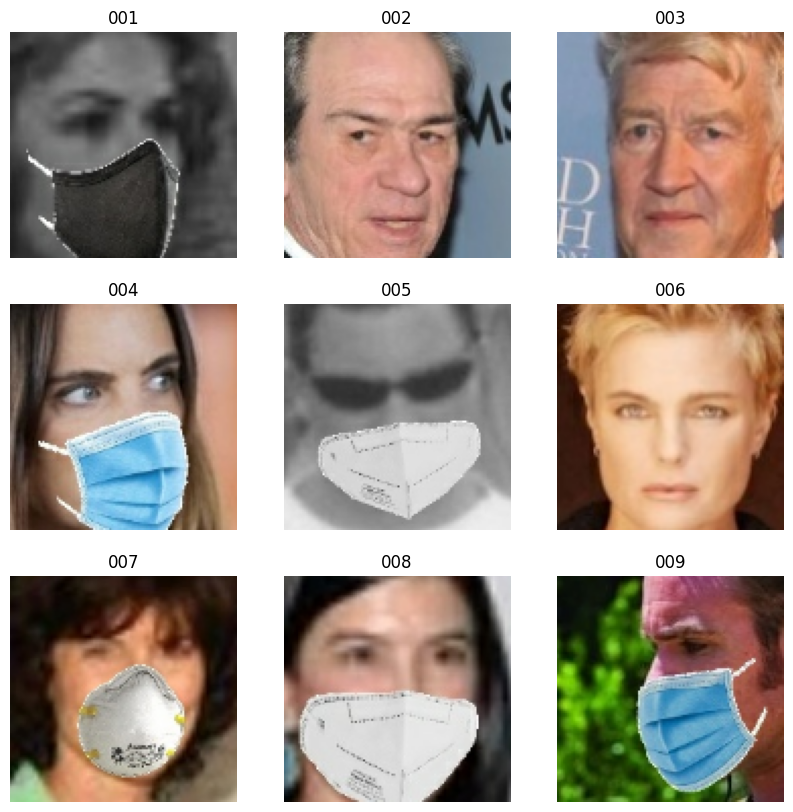

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

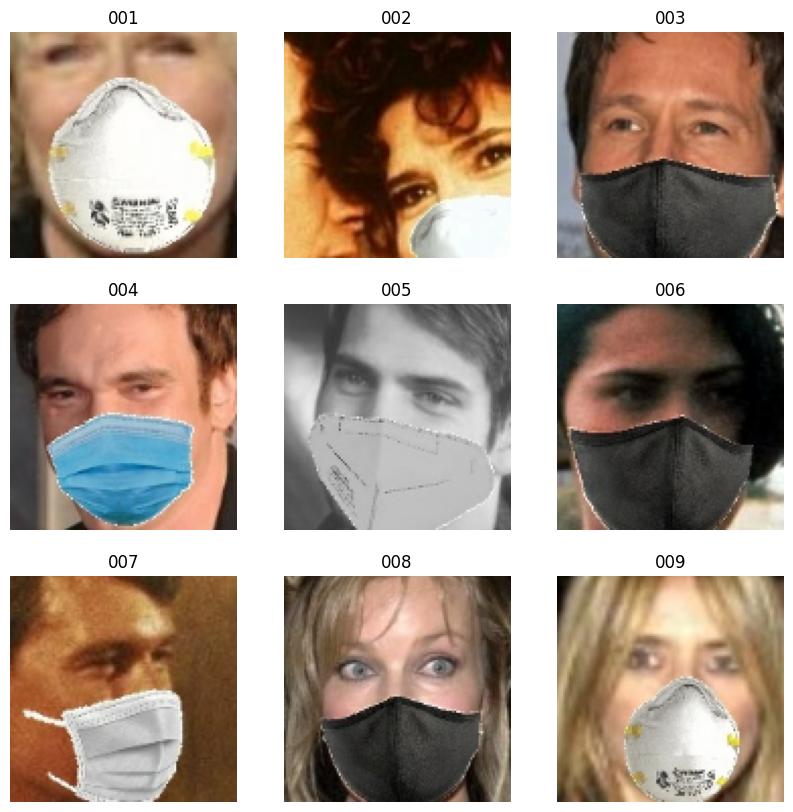

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

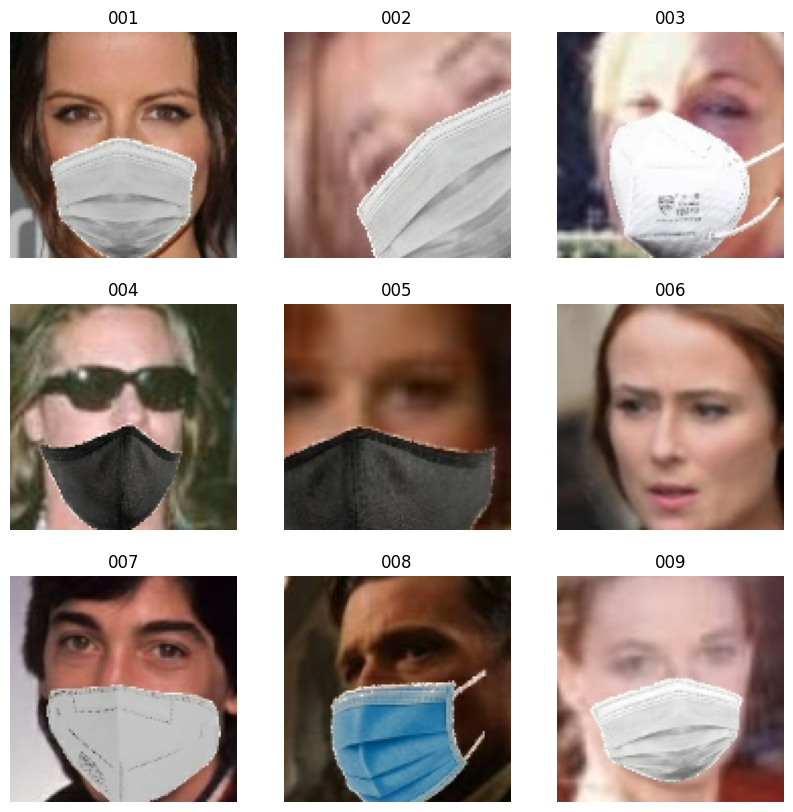

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(4):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

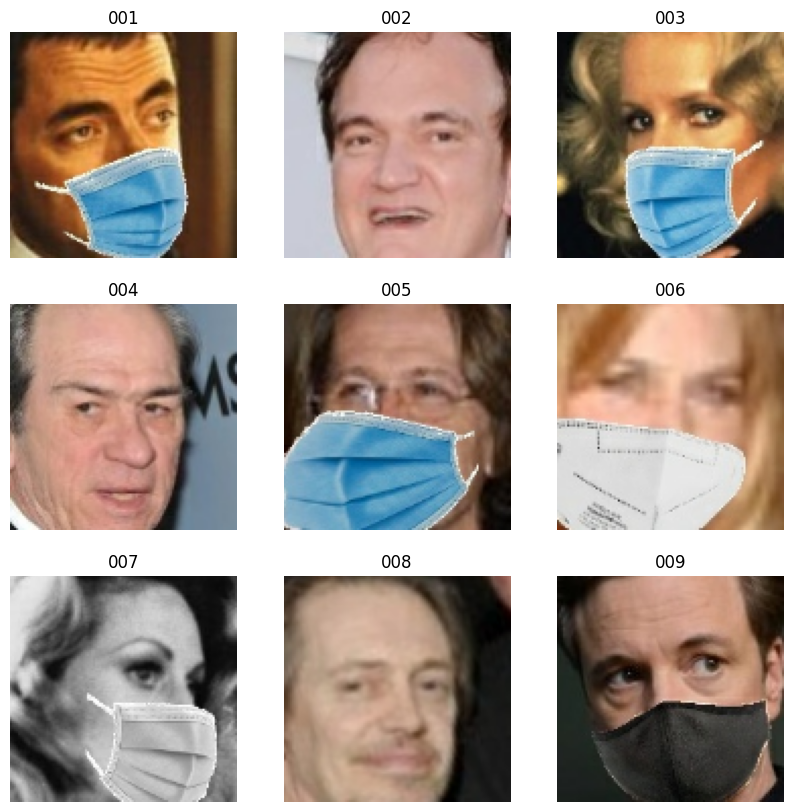

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(type(image_batch))
  print(type(labels_batch))
  break


(64, 112, 112, 3)
(64, 88)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


### Arc Face

In [41]:
# arcface = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Biometrics/arcface_model.keras')

In [42]:
arcface = tf.keras.models.load_model(path_arcface)

In [43]:
arcface.summary()

Model: "arcface_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 112, 112, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 OutputLayer (Functional)    (None, 512)               16787968  
                                                                 
Total params: 40,375,680
Trainable params: 40,317,440
Non-trainable params: 58,240
_________________________________________________________________


In [44]:
from tensorflow.keras import layers

In [45]:
# Add a softmax layer after the final layer
arcface_output = layers.Dense(88)(arcface.output)
softmax_output = layers.Softmax()(arcface_output)

# Create a new model with the same inputs as arcface and the new softmax output
Arcface = tf.keras.Model(inputs=arcface.input, outputs=softmax_output)

In [46]:
Arcface.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 112, 112, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 OutputLayer (Functional)    (None, 512)               16787968  
                                                                 
 dense (Dense)               (None, 88)                45144     
                                                                 
 softmax (Softmax)           (None, 88)                0         
                                                                 
Total params: 40,420,824
Trainable params: 40,362,584
Non-trainable params: 58,240
_________________________________________________________________


In [47]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy

In [48]:
from tensorflow.keras import regularizers

# Add L2 regularization to the last dense layer
regularization = regularizers.l2(0.01)

In [49]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

In [50]:
# Compile the model with a regularization loss term
optimizer = Adam(learning_rate=0.001)
loss_fn = SparseCategoricalCrossentropy()
regularization_loss = sum(Arcface.losses)
total_loss_fn = lambda y_true, y_pred: loss_fn(y_true, y_pred) + regularization_loss
Arcface.compile(optimizer=optimizer, loss=total_loss_fn, metrics=['accuracy'], jit_compile=True)

In [51]:
# Fit the model
epochs = 10
history = Arcface.fit(train_ds_int, epochs=epochs, validation_data=val_ds_int, callbacks=[lr_scheduler])

Epoch 1/10
22/22 [==============================] - 110s 2s/step - loss: 6.8775 - accuracy: 0.2558 - val_loss: 7.9815 - val_accuracy: 0.0437 - lr: 0.0010
Epoch 2/10
22/22 [==============================] - 4s 183ms/step - loss: 3.8067 - accuracy: 0.8779 - val_loss: 7.1771 - val_accuracy: 0.1399 - lr: 0.0010
Epoch 3/10
22/22 [==============================] - 4s 187ms/step - loss: 3.3005 - accuracy: 0.9847 - val_loss: 6.0463 - val_accuracy: 0.3848 - lr: 0.0010
Epoch 4/10
22/22 [==============================] - 4s 177ms/step - loss: 3.1314 - accuracy: 0.9898 - val_loss: 5.2214 - val_accuracy: 0.5015 - lr: 0.0010
Epoch 5/10
22/22 [==============================] - 4s 177ms/step - loss: 2.9591 - accuracy: 0.9891 - val_loss: 4.7597 - val_accuracy: 0.5481 - lr: 0.0010
Epoch 6/10
22/22 [==============================] - 4s 187ms/step - loss: 2.7872 - accuracy: 0.9920 - val_loss: 4.5558 - val_accuracy: 0.5627 - lr: 0.0010
Epoch 7/10
22/22 [==============================] - 4s 189ms/step - los

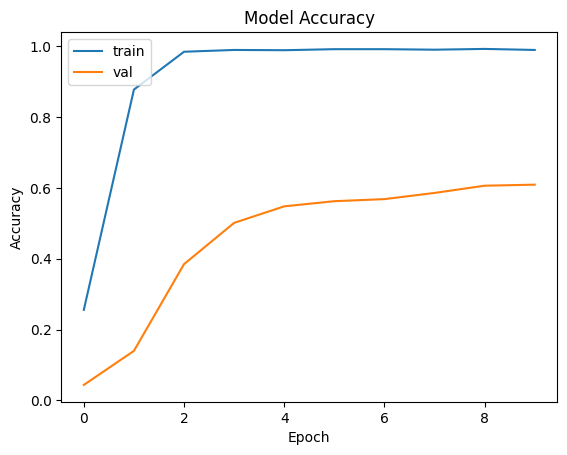

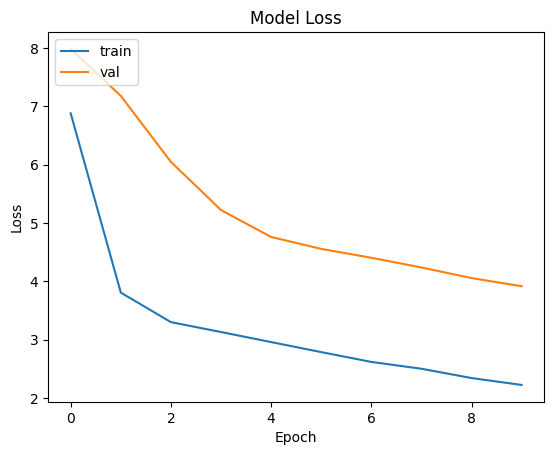

In [52]:

# plot accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Creating Imposter dataset.

In [72]:
dataset_path = '/content/combined'

In [73]:
num_folders = 10

In [74]:
folders = os.listdir(dataset_path)

In [75]:
# Create a set of the selected folders
selected_set = set(selected_folders)

# Choose 25 random folders that are not in the selected set
available_folders = set(folders) - selected_set
selected_folders_imposter = np.random.choice(list(available_folders), num_folders, replace=False)

In [83]:
len(selected_set)

90

In [84]:
selected_set

{'001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '014',
 '015',
 '016',
 '017',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '042',
 '043',
 '044',
 '045',
 '046',
 '048',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '065',
 '066',
 '067',
 '069',
 '070',
 '071',
 '073',
 '074',
 '075',
 '076',
 '078',
 '080',
 '082',
 '083',
 '084',
 '085',
 '086',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '48'}

In [76]:
len(selected_folders_imposter)

10

In [77]:
selected_folders_imposter

array(['041', '018', '068', '049', '103', '079', '088', '077', '013',
       '087'], dtype='<U3')

In [78]:
new_dataset_path = '/content/imposter'

In [79]:
if not os.path.exists(new_dataset_path):
    os.makedirs(new_dataset_path)

In [86]:
extract_faces(selected_folders_imposter, '/content/combined', new_dataset_path, 10)

In [87]:
count_folders_and_images('/content/imposter')

Number of folders: 10
Number of images: 193


In [88]:
img_height, img_width = 112, 112

In [89]:
imposter_ds = tf.keras.utils.image_dataset_from_directory(
  new_dataset_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 193 files belonging to 10 classes.


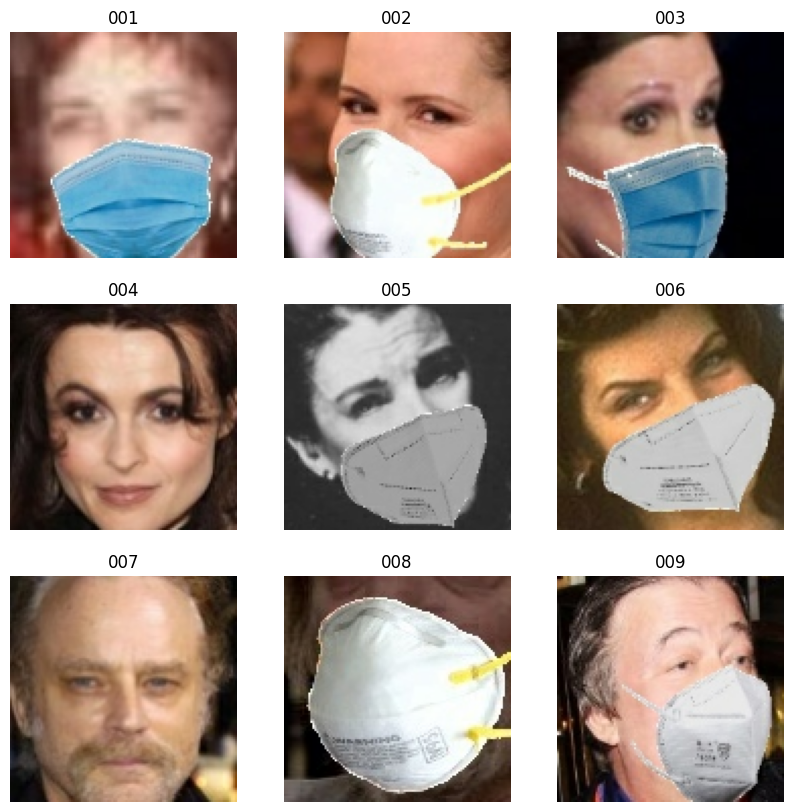

In [90]:
plt.figure(figsize=(10, 10))
for images, labels in imposter_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

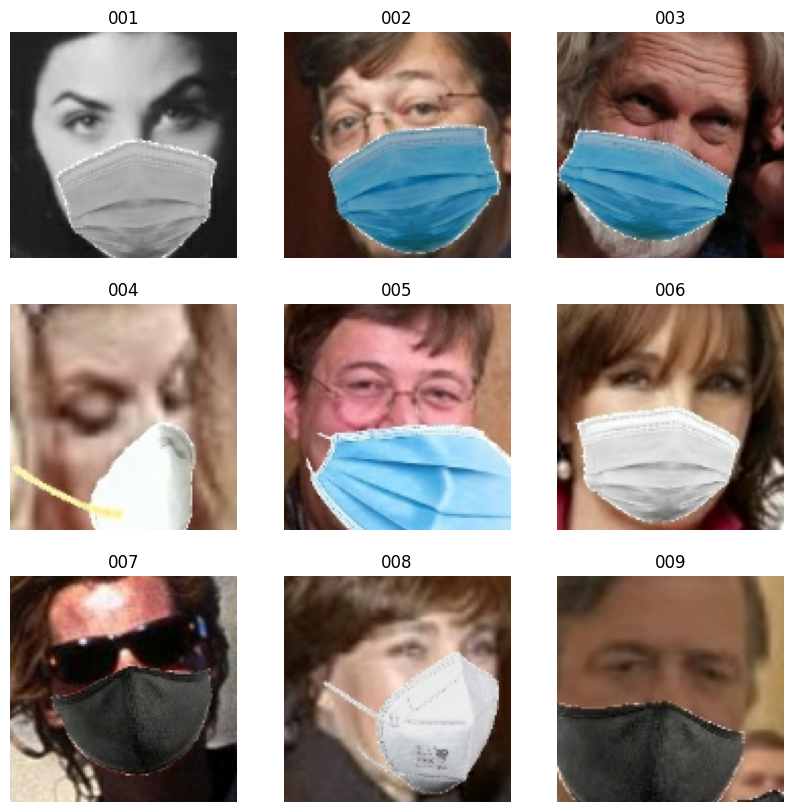

In [91]:
plt.figure(figsize=(10, 10))
for images, labels in imposter_ds.take(6):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [92]:
type(imposter_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

### DET Curve

In [138]:
train_embeddings = []

In [146]:
train_ds_int_shuffled = train_ds_int.shuffle(buffer_size=1376, reshuffle_each_iteration=False)
train_subset = train_ds_int_shuffled.take(193) # replace 193 with the size of imposter_ds

In [147]:
train_subset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [148]:
type(train_subset)

tensorflow.python.data.ops.take_op._TakeDataset

In [149]:
train_embeddings = Arcface.predict(train_subset)

22/22 [==============================] - 2s 49ms/step


In [150]:
type(train_embeddings)

numpy.ndarray

In [151]:
train_embeddings.shape

(1376, 88)

In [152]:
# crop the train_embeddings array to match the size of imposter_embeddings
train_embeddings = train_embeddings[:193, :]

In [153]:
train_embeddings.shape

(193, 88)

In [154]:
imposter_embeddings = Arcface.predict(imposter_ds)

7/7 [==============================] - 1s 45ms/step


In [155]:
imposter_embeddings.shape

(193, 88)

In [156]:
# Calculate the distances between genuine_embeddings and imposter_embeddings
genuine_distances = np.linalg.norm(train_embeddings - train_embeddings.mean(axis=0), axis=1)
imposter_distances = np.linalg.norm(imposter_embeddings - train_embeddings.mean(axis=0), axis=1)

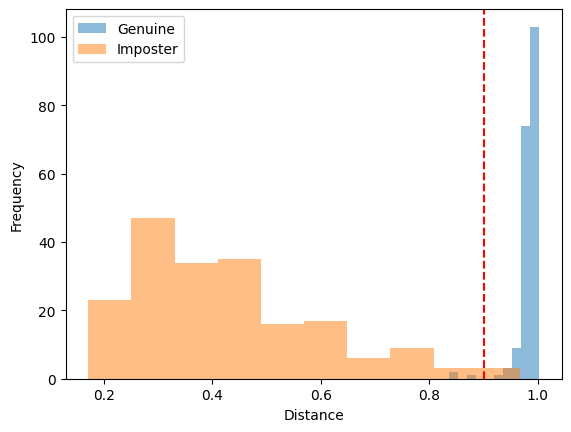

In [158]:
# Plot the distribution of genuine and imposter distances
plt.hist(genuine_distances, alpha=0.5, label='Genuine')
plt.hist(imposter_distances, alpha=0.5, label='Imposter')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()

# Add a threshold line
threshold = 0.9  # replace with your desired threshold value
plt.axvline(x=threshold, color='r', linestyle='--')


plt.show()

### Conclusion

We have tried over 5 models with varying hyperparameters and ArcFace has given us the best results to create a Biometric Identification system using Face recognition with masks.